## Import modules

In [271]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import collections

## Download train/test data

In [2]:
train_data = datasets.MNIST(root='data',
                      train=True,
                      download=True,
                      transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())

## Create dataloader

In [3]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=64,
                              shuffle=False)

## Build model

In [5]:
class VAE(nn.Module):
    def __init__(self,
                 in_channel :int):
        super().__init__()

        self.encoder = nn.Sequential(          #-----> input size : (1, 1, 28, 28)
            nn.Conv2d(in_channels=in_channel,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),              #-----> (1, 32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1),              #-----> (1, 64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1),              #-----> (1, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),              #-----> (1, 64, 7, 7)
            nn.ReLU(),
            nn.Flatten()                       #-----> (1, 3136)
        )

        self.mu = nn.Linear(in_features=3136,
                            out_features=2)
        self.sigma = nn.Linear(in_features=3136,
                               out_features=2)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2,
                      out_features=3136),               #------>(1, 3136)
            nn.Unflatten(dim=1,
                         unflattened_size=(64, 7, 7)),     #------->(1, 64, 7, 7)
            nn.ConvTranspose2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      output_padding=0),                 #-------->(1, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1,
                      output_padding=1),              #-----> (1, 64, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,
                      out_channels=32,
                      kernel_size=3,
                      stride=2,
                      padding=1,
                      output_padding=1),              #-----> (1, 32, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32,
                      out_channels=1,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      output_padding=0),           #-----------> (1, 1, 28, 28)
            nn.Sigmoid()
        )

    def reparemeterization_trick(self, mu, sigma):
         std = torch.exp(0.5*sigma)
         eps = torch.randn_like(std)
         z = mu + eps*std
         return z
    
    def encode(self, X : torch.Tensor):
         mu = self.mu(self.encoder(X))
         sigma = self.sigma(self.encoder(X))
         z = self.reparemeterization_trick(mu, sigma)
         return mu, sigma, z
    
    def decode(self, z : torch.Tensor):
         return self.decoder(z)
             
    def forward(self,
                X :torch.Tensor):
          mu, sigma, z = self.encode(X)
          decoded = self.decode(z)
          return decoded, mu, sigma, z

## Define model

In [6]:
model = VAE(in_channel=1)


## Define loss function and optimizer

In [7]:
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

def loss_fn(reconstructed, X, mu, sigma):
    MSE = nn.functional.mse_loss(reconstructed, X, reduction='sum')
    KLD = -0.5 * torch.sum(1 + sigma - mu**2 - torch.exp(sigma))
    loss = MSE + KLD
    return loss

decoded, mu, sigma, z = model(x)
loss_fn(decoded, x, mu, sigma)

tensor(10430.1064, grad_fn=<AddBackward0>)

## Define train/evaluation function

In [9]:
def train(model :nn.Module,
          loss_fn :nn.functional,
          optimizer :torch.optim,
          data :torch.Tensor):
    model.train()
    train_loss = 0
    for X_train,_ in data:
        optimizer.zero_grad()
        decode, mu, sigma, z = model(X_train)
        loss_train = loss_fn(decode, X_train, mu, sigma)
        loss_train.backward()
        optimizer.step()
        train_loss += loss_train
    train_loss /= len(train_dataloader)
    return train_loss

def eval(model :nn.Module,
         loss_fn :nn.functional,
         data :torch.Tensor):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        for X_test,_ in test_dataloader:
            decode, mu, sigma, z = model(X_test)
            test_loss += loss_fn(decode, X_test, mu, sigma) 
        test_loss /= len(test_dataloader)
    return test_loss

## Train model

In [31]:
epochs = 10
for epoch in range(1, epochs+1):
    train_loss = train(model=model,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       data=train_dataloader)
    test_loss = eval(model=model,
                     loss_fn=loss_fn,
                     data=test_dataloader)
    print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Test_loss : {test_loss :.3f}")

Epoch : 1 | Train_loss : 2204.929 | Test_loss : 2269.011
Epoch : 2 | Train_loss : 2202.481 | Test_loss : 2260.424
Epoch : 3 | Train_loss : 2202.647 | Test_loss : 2253.193
Epoch : 4 | Train_loss : 2203.665 | Test_loss : 2256.094
Epoch : 5 | Train_loss : 2202.074 | Test_loss : 2260.245
Epoch : 6 | Train_loss : 2201.569 | Test_loss : 2255.542
Epoch : 7 | Train_loss : 2198.645 | Test_loss : 2250.252
Epoch : 8 | Train_loss : 2199.399 | Test_loss : 2264.042
Epoch : 9 | Train_loss : 2200.300 | Test_loss : 2248.783
Epoch : 10 | Train_loss : 2198.653 | Test_loss : 2251.523


## Visualize latent space

In [153]:
class LatentSpace():
    def __init__(self,
                 model :nn.Module,
                 data :torch.Tensor):
        self.model = model
        self.data = data

    def latent_values(self):
        latent_values_unsorted = {}
        with torch.inference_mode():
            for X,y in self.data:
                decode, mu, logvar, z = self.model(X.unsqueeze(0))
                if f'z{y}' in latent_values_unsorted.keys():
                    latent_values_unsorted[f'z{y}'][0].append(z[0][0])
                    latent_values_unsorted[f'z{y}'][1].append(z[0][1])
                else:
                    latent_values_unsorted[f'z{y}'] = [[], []]
                    latent_values_unsorted[f'z{y}'][0].append(z[0][0])
                    latent_values_unsorted[f'z{y}'][1].append(z[0][1])
        keys = sorted(latent_values_unsorted)
        latent_values = {}
        for i in keys:
            latent_values[i] = latent_values_unsorted[i]

        return latent_values
    
    def data_matrix(self):
        matrix = torch.zeros(len(self.data), 2)
        with torch.inference_mode():
            for i, (X,y) in enumerate(self.data):
                decode, mu, logvar, z = self.model(X.unsqueeze(0))
                matrix[i][0] = z[0][0].item()
                matrix[i][1] = z[0][1].item()
        return matrix
    
    def plot_latent_space(self):
        latent_space = self.latent_values()
        plt.figure(figsize=(5, 5))
        plt.title('2D Latent Space')
        plt.xlabel('z_1')
        plt.ylabel('z_2')
        for z_values in latent_space:
            plt.scatter(latent_space[z_values][0], latent_space[z_values][1], label=z_values)
        plt.legend(prop={'size':8})
        plt.show()
    


latent = LatentSpace(model=model,
                     data=test_data)


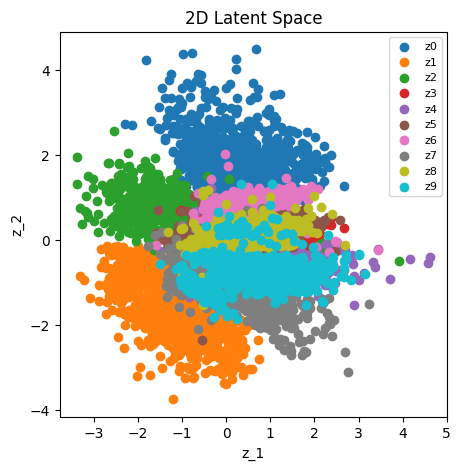

In [196]:
latent.plot_latent_space()

In [272]:
torch.jit.script(model).save('vae.pt')